In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import constants as const
import db_operations as dbop
import data_prepare as dp
import ml_model

import xgboost.sklearn as xgb
import lightgbm.sklearn as lgbm
import sklearn.preprocessing as preproc
import sklearn.metrics as metrics

import datetime
import time

2018-01-01 2011-02-27 2009-02-07
start: 2009-02-07


min_date 2009-02-09


count stck 58
(119802, 143)
(119802, 143)


(2389, 395) 2389


(119802, 538)


df_all: (99573, 538)


y<-0.5: 0
-0.50<=y<-0.40: 1
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 2
-0.20<=y<-0.10: 49
-0.10<=y<0.00: 6589
0.00<=y<0.10: 54713
0.10<=y<0.20: 23622
0.20<=y<0.30: 7906
0.30<=y<0.40: 2857
0.40<=y<0.50: 1189
y>0.5 1483
mean: 0.10512079369721224 median: 0.07169344870210126 std: 0.2097293200331299


过滤涨停项或停牌（最高价=最低价）： 5408
y<-0.5: 0
-0.50<=y<-0.40: 0
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 0
-0.20<=y<-0.10: 45
-0.10<=y<0.00: 6521
0.00<=y<0.10: 56321
0.10<=y<0.20: 23167
0.20<=y<0.30: 7618
0.30<=y<0.40: 2634
0.40<=y<0.50: 1056
y>0.5 1049
mean: 0.09602441787210458 median: 0.06809229037704001 std: 0.10939949226881739


y<-0.5: 259
-0.50<=y<-0.40: 449
-0.40<=y<-0.30: 1373
-0.30<=y<-0.20: 4773
-0.20<=y<-0.10: 22424
-0.10<=y<0.00: 63870
0.00<=y<0.10: 5265
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.07977053948760486 median: -0.05882352941176483 std: 0.07881259561400997


过滤涨停项或停牌（最高价=最低价）： 5408
y<-0.5: 187
-0.50<=y<-0.40: 373
-0.40<=y<-0.30: 1281
-0.30<=y<-0.20: 4608
-0.20<=y<-0.10: 21963
-0.10<=y<0.00: 63145
0.00<=y<0.10: 6856
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.07717436043985301 median: -0.0567685589519652 std: 0.07601330776604871


y<-0.5: 1
-0.50<=y<-0.40: 1
-0.40<=y<-0.30: 1
-0.30<=y<-0.20: 5
-0.20<=y<-0.10: 105
-0.10<=y<0.00: 13746
0.00<=y<0.10: 73922
0.10<=y<0.20: 9446
0.20<=y<0.30: 1524
0.30<=y<0.40: 361
0.40<=y<0.50: 141
y>0.5 30
mean: 0.043285505179587264 median: 0.02985074626865658 std: 0.12901851455671642


过滤涨停项或停牌（最高价=最低价）： 5408
y<-0.5: 0
-0.50<=y<-0.40: 0
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 4
-0.20<=y<-0.10: 99
-0.10<=y<0.00: 13641
0.00<=y<0.10: 74624
0.10<=y<0.20: 9196
0.20<=y<0.30: 1353
0.30<=y<0.40: 286
0.40<=y<0.50: 66
y>0.5 14
mean: 0.040788955311571055 median: 0.02887139107611536 std: 0.05356288397582179


y<-0.5: 8
-0.50<=y<-0.40: 11
-0.40<=y<-0.30: 138
-0.30<=y<-0.20: 792
-0.20<=y<-0.10: 7292
-0.10<=y<0.00: 83542
0.00<=y<0.10: 7500
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.04039733274113943 median: -0.028132992327365547 std: 0.042994759228890206


过滤涨停项或停牌（最高价=最低价）： 5408
y<-0.5: 0
-0.50<=y<-0.40: 7
-0.40<=y<-0.30: 121
-0.30<=y<-0.20: 767
-0.20<=y<-0.10: 7121
-0.10<=y<0.00: 82978
0.00<=y<0.10: 8289
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.03970314220265873 median: -0.027626459143968995 std: 0.04197491124530424


(99573, 521) (99573, 4) Index(['y_l_rise', 'y_l_decline', 'y_s_rise', 'y_s_decline'], dtype='object')


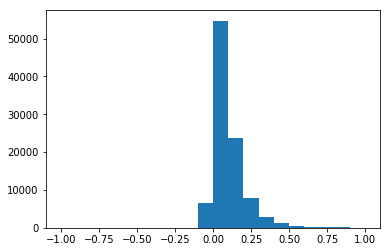

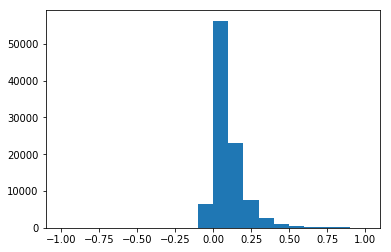

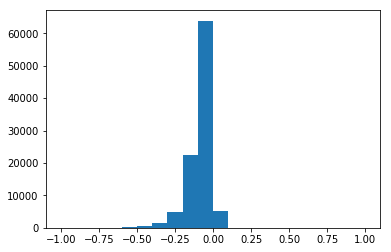

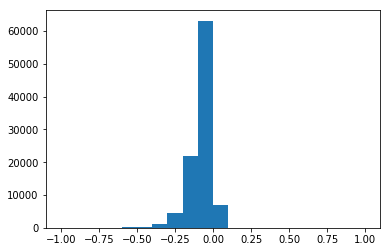

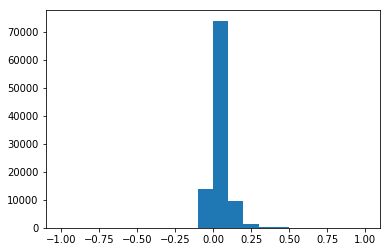

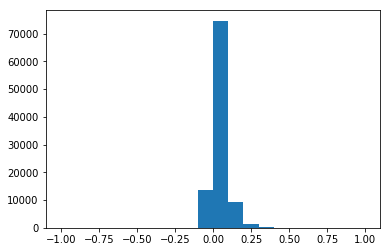

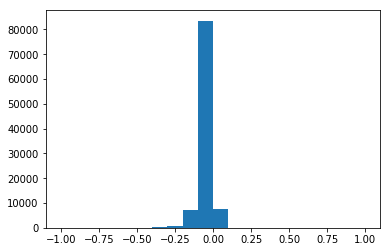

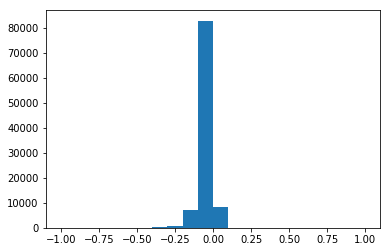

In [3]:
targets = [{"period": 20, "fun": "max", "col": "high"},
                   {"period": 20, "fun": "min", "col": "low"},
                   {"period": 5, "fun": "max", "col": "high"},
                   {"period": 5, "fun": "min", "col": "low"}]

time_delta = datetime.timedelta(days=1)
test_start = "2018-01-01"
train_length = 2500
max_feature_length = 750

train_bound = datetime.datetime.strptime(test_start, const.DATE_FORMAT) - train_length * time_delta
train_bound = datetime.datetime.strftime(train_bound, const.DATE_FORMAT)

lower_bound = datetime.datetime.strptime(train_bound, const.DATE_FORMAT) - max_feature_length * time_delta
lower_bound = datetime.datetime.strftime(lower_bound, const.DATE_FORMAT)
print(test_start,train_bound,lower_bound)

df_all, cols_future = ml_model.gen_data(targets=targets,
                                        lower_bound=lower_bound,
                                        start=train_bound,
                                        stock_pool=None)

print("df_all:", df_all.shape)
trading_date_idxes = df_all.index.unique().sort_values(ascending=True)

X = ml_model.gen_X(df_all, cols_future)

paras = [("y_l_rise", {"pred_period": 20, "is_high": True, "is_clf": False,"threshold":0.2}, df_all),
         ("y_l_decline", {"pred_period": 20, "is_high": False, "is_clf": False, "threshold":0.2}, df_all),
         ("y_s_rise", {"pred_period": 5, "is_high": True, "is_clf": False,"threshold":0.1}, df_all),
         ("y_s_decline", {"pred_period": 5, "is_high": False, "is_clf": False,"threshold":0.1}, df_all), ]
Y = pd.concat([ml_model.gen_y(v2, **v1) for k, v1, v2 in paras], axis=1)
Y.columns = [k for k, _, _ in paras]
Y.index = X.index
print(X.shape, Y.shape, Y.columns)

In [4]:
# Y is contiguous.
for col in Y.columns:
    print(col, Y[col].mean(),Y[col].median(),Y[col].std())

y_l_rise 0.09602441787210458 0.06809229037704001 0.10939949226881739
y_l_decline -0.07717436043985301 -0.0567685589519652 0.07601330776604871
y_s_rise 0.040788955311571055 0.02887139107611536 0.05356288397582179
y_s_decline -0.03970314220265873 -0.027626459143968995 0.04197491124530424


In [5]:
models = {"model_l_high":
              lgbm.LGBMClassifier(n_estimators=100,
                                 num_leaves=128, max_depth=10,
                                 random_state=0, min_child_samples=20)}
    
train_date_idx = trading_date_idxes[trading_date_idxes<"2018-01-01"][:-21]
print(train_date_idx[0],train_date_idx[-1])
test_date_idx = trading_date_idxes[trading_date_idxes>="2018-01-01"][:-20]
print(test_date_idx[0],test_date_idx[-1])

ycol = "y_l_rise"
X_train = X.loc[train_date_idx]
Y_train = {ycol:Y.loc[train_date_idx, ycol]}
print(X_train.shape, Y_train[ycol].shape)
X_test = X.loc[test_date_idx]
Y_test = {ycol:Y.loc[test_date_idx,ycol]}
print(X_test.shape, Y_test[ycol].shape)

y_train = ml_model.label(Y_train[ycol],threshold=0.2,is_high=True)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

t1 = time.time()
models["model_l_high"].fit(X_train, y_train)
t2 = time.time()
Y_test_pred ={ycol: models["model_l_high"].predict_proba(X_test)[:,1]}


2011-02-28 2017-11-30
2018-01-02 2018-10-31


(85662, 521) (85662,)
(11554, 521) (11554,)


7835 (0.06472447539175624, 0.04646464646464632, 0.0749184875220568, 0.7545388525780681, -0.18314559866499802)
2309 (0.09240231875653361, 0.07157464212678954, 0.0955055810965893, 0.8724528301886791, -0.19402173913043474)
746 (0.09833865090215828, 0.07481669740452523, 0.10855264560647691, 0.8832684824902723, -0.11037410453701235)
317 (0.11417812998783967, 0.08305084745762703, 0.12316916415177248, 0.6894409937888195, -0.0837500000000001)
146 (0.12987905100866382, 0.1012926662346203, 0.12185581014219485, 0.6316736652669463, -0.042395693135935164)
78 (0.1433569018888267, 0.1307065545618301, 0.11214518688005297, 0.4766917293233084, -0.030726256983240163)
61 (0.13325395122571507, 0.12472806381435819, 0.11243756817706707, 0.49695121951219523, -0.07688532635367262)
41 (0.15095245129064339, 0.133546581367453, 0.11289145690794583, 0.44268774703557323, -0.0774077407740773)
17 (0.10089014536275849, 0.0795275590551181, 0.10983857355783053, 0.3786666666666667, -0.02530802530802534)
4 (0.0690997454031

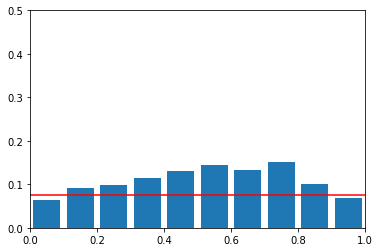

In [6]:
x0 = np.arange(11)*0.1
y0 = np.ones(x0.shape)* Y_test[ycol].mean()

y1 = []
cnt1 = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    cond=(p0 < Y_test_pred[ycol]) & (Y_test_pred[ycol] <=p1)
    cnt1.append(sum(cond))
    y1.append((Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min()))
for c,p in zip(cnt1,y1):
    print(c,p)

plt.bar(np.arange(len(y1))*0.1+0.05,[mean for mean,_, _,_,_ in y1],width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

In [7]:
cols = ["open","close","high","low"]
cols = cols + [c+"0" for c in cols]
print(cols)
# for idx,row in X_test[Y_test_pred[ycol]>0.7][cols].iterrows():
#     print(idx,)
df_test = X_test[cols].copy()
df_test["code"] = df_all.loc[test_date_idx]["code"]
df_test[ycol+"_pred"]=Y_test_pred[ycol]
df_test[ycol] = Y_test[ycol]
df_print = df_test[Y_test_pred[ycol]>0.7]
for code,df in df_print.groupby("code"):
    print("\n","-"*10,"\ncode:",code)
    print(df[df.columns.difference(["code"])].sort_index().applymap(lambda x:round(x,2)))


['open', 'close', 'high', 'low', 'open0', 'close0', 'high0', 'low0']



 ---------- 
code: 000063.SZ
             close  close0    high  high0     low   low0    open  open0  \
2018-10-09  265.22   16.80  269.64  17.08  260.49  16.50  265.70  16.83   
2018-10-11  239.49   15.17  253.85  16.08  239.49  15.17  253.85  16.08   
2018-10-12  246.28   15.60  250.22  15.85  228.91  14.50  236.81  15.00   
2018-10-16  247.86   15.70  254.17  16.10  245.96  15.58  252.91  16.02   
2018-10-18  247.86   15.70  253.38  16.05  246.12  15.59  252.59  16.00   
2018-10-23  273.75   17.34  282.11  17.87  268.85  17.03  281.01  17.80   
2018-10-26  272.33   17.25  283.38  17.95  267.43  16.94  278.32  17.63   
2018-10-29  275.48   17.45  281.32  17.82  268.22  16.99  272.33  17.25   

            y_l_rise  y_l_rise_pred  
2018-10-09      0.14           0.81  
2018-10-11      0.38           0.81  
2018-10-12      0.33           0.74  
2018-10-16      0.29           0.80  
2018-10-18      0.35           0.71  
2018-10-23      0.28           0.73  
2018-10-26      0.27        

             close  close0    high  high0     low   low0    open  open0  \
2018-09-17  243.40   14.37  246.79  14.57  238.66  14.09  242.72  14.33   
2018-10-09  225.44   13.31  230.53  13.61  218.33  12.89  228.32  13.48   

            y_l_rise  y_l_rise_pred  
2018-09-17      0.08           0.72  
2018-10-09      0.12           0.76  

 ---------- 
code: 002236.SZ
             close  close0    high  high0     low   low0    open  open0  \
2018-09-18  580.32    13.8  581.58  13.83  544.15  12.94  574.01  13.65   
2018-10-11  538.27    12.8  554.25  13.18  529.01  12.58  537.85  12.79   

            y_l_rise  y_l_rise_pred  
2018-09-18      0.13           0.77  
2018-10-11      0.08           0.82  

 ---------- 
code: 002335.SZ
            close  close0  high  high0   low  low0  open  open0  y_l_rise  \
2018-10-11  43.09   13.83  46.3  14.86  43.0  13.8  46.3  14.86      0.05   

            y_l_rise_pred  
2018-10-11           0.71  

 ---------- 
code: 002359.SZ
            close  

            close  close0   high  high0    low   low0   open  open0  y_l_rise  \
2018-09-10  30.23   30.08  32.03  31.87  29.88  29.73  32.03  31.87      0.07   
2018-09-14  30.60   30.45  31.92  31.76  30.45  30.30  31.74  31.58      0.01   
2018-09-17  29.63   29.48  30.89  30.74  29.25  29.10  30.52  30.37      0.04   
2018-09-18  30.16   30.01  30.36  30.21  29.30  29.15  29.85  29.70     -0.03   
2018-09-19  30.42   30.27  30.95  30.80  29.77  29.62  30.18  30.03     -0.02   
2018-09-20  28.41   28.27  29.42  29.27  27.94  27.80  29.16  29.01      0.02   
2018-09-25  28.36   28.22  28.70  28.56  28.26  28.12  28.60  28.46     -0.01   
2018-10-08  25.23   25.10  26.58  26.45  25.15  25.02  26.41  26.28      0.09   
2018-10-09  26.33   26.20  27.01  26.88  25.29  25.16  25.56  25.43      0.00   
2018-10-11  25.05   24.93  26.42  26.29  24.65  24.53  26.34  26.21      0.04   
2018-10-15  24.82   24.70  24.91  24.79  23.03  22.92  23.82  23.70      0.08   
2018-10-16  24.01   23.89  2